# Treasury Trading Optimization: Python Comparison
This notebook compares optimization engines (MOSEK, Gurobi, CPLEX, Xpress, SCIP, CVXOPT, KNITRO) for a convex optimization problem in treasury trading using 2024 U.S. Treasury real yield curve data. The objective is to minimize funding costs while accounting for haircuts, interest rates, and transfer fees.

In [41]:
!pip install pandas numpy requests mosek gurobipy cplex pyscipopt cvxopt matplotlib seaborn


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data Retrieval

In [42]:
import pandas as pd
import requests

# URL for 2024 Treasury real yield curve data
url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/2024/all?type=daily_treasury_real_yield_curve&field_tdr_date_value=2024&page&_format=csv"
response = requests.get(url)

# Check if the request was successful
if response.status_code != 200:
    raise Exception(f"Failed to fetch data: HTTP {response.status_code}")

# Save the content to a file
with open("treasury_2024.csv", "wb") as f:
    f.write(response.content)

# Load and process data
data = pd.read_csv("treasury_2024.csv")

# Print column names to debug
print("Available columns in the CSV:", data.columns.tolist())

# Convert "Date" column to datetime
if "Date" not in data.columns:
    raise KeyError("Column 'Date' not found in the CSV")
data["Date"] = pd.to_datetime(data["Date"])

# Define expected maturity columns based on your sample
expected_columns = ["Date", "5 YR", "7 YR", "10 YR", "20 YR", "30 YR"]

# Check if all expected columns are present
missing_columns = [col for col in expected_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"Columns {missing_columns} not found in the CSV")

# Select and clean the data
rates = data[expected_columns].dropna()
print(rates.tail())

Available columns in the CSV: ['Date', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']
          Date  5 YR  7 YR  10 YR  20 YR  30 YR
245 2024-01-08  1.78  1.79   1.79   1.90   1.98
246 2024-01-05  1.83  1.83   1.83   1.94   2.02
247 2024-01-04  1.79  1.78   1.77   1.88   1.96
248 2024-01-03  1.73  1.71   1.71   1.81   1.89
249 2024-01-02  1.76  1.75   1.74   1.84   1.91


## Problem Definition
- **Objective**: Minimize funding costs = $\sum (w_i \cdot r_i + f_i)$
- **Constraints**:
  - $\sum w_i = 1$ (full allocation)
  - $w_i \geq h_i = 0.02$ (haircut constraint)
  - $w_i \geq 0$ (non-negative weights)
- **Parameters**:
  - $r_i$: Latest real yields (5, 10, 20, 30-year treasuries)
  - $h_i = 0.02$: Haircut of 2%
  - $f_i = 0.001$: Transfer fee of 0.1%

In [43]:
import numpy as np
# ... (after data retrieval)
r = rates.iloc[-1, 1:].values / 100  # [0.02, 0.0213, 0.0224, 0.0240, 0.0247] from 12/30/2024
h = np.array([0.02] * 5)  # Haircuts for 5 maturities
f = np.array([0.001] * 5)  # Fees for 5 maturities
n = len(r)  # Now 5
# ... (rest of the optimization code remains the same, just with 5 variables)

## Optimization Engines

In [44]:
# MOSEK
# from mosek.fusion import Model, Domain, Expr
# with Model("TreasuryOpt") as M:
#     w = M.variable("w", n, Domain.greaterThan(0.0))
#     M.constraint("budget", Expr.sum(w), Domain.equalsTo(1.0))
#     M.constraint("haircut", w, Domain.greaterThan(h))
#     cost = Expr.add(Expr.dot(w, r), Expr.constTerm(f.sum()))
#     M.objective("obj", ObjectiveSense.Minimize, cost)
#     M.solve()
#     w_mosek = w.level()
#     cost_mosek = M.primalObjValue()
# print(f"MOSEK: Weights = {w_mosek}, Cost = {cost_mosek}")

# MOSEK
from mosek.fusion import Model, Domain, Expr, ObjectiveSense
import numpy as np

# Assuming r, h, f, and n are defined earlier
# Ensure r is a float64 array
r = rates.iloc[-1, 1:].values.astype(np.float64) / 100  # Convert to float and scale
h = np.array([0.02] * len(r))  # Haircuts
f = np.array([0.001] * len(r))  # Fees
n = len(r)

with Model("TreasuryOpt") as M:
    w = M.variable("w", n, Domain.greaterThan(0.0))
    M.constraint("budget", Expr.sum(w), Domain.equalsTo(1.0))
    M.constraint("haircut", w, Domain.greaterThan(h))
    # Ensure r is a float array for dot product
    cost = Expr.add(Expr.dot(w, r.astype(np.float64)), Expr.constTerm(f.sum()))
    M.objective("obj", ObjectiveSense.Minimize, cost)
    M.solve()
    w_mosek = w.level()
    cost_mosek = M.primalObjValue()
print(f"MOSEK: Weights = {w_mosek}, Cost = {cost_mosek}")

MOSEK: Weights = [0.02 0.02 0.92 0.02 0.02], Cost = 0.022459999999999997


In [45]:
# Gurobi
from gurobipy import Model, GRB
m = Model("TreasuryOpt")
w = m.addVars(n, lb=0, name="w")
m.addConstr(sum(w[i] for i in range(n)) == 1, "budget")
for i in range(n):
    m.addConstr(w[i] >= h[i], f"haircut_{i}")
m.setObjective(sum(w[i] * r[i] for i in range(n)) + f.sum(), GRB.MINIMIZE)
m.optimize()
w_gurobi = [w[i].x for i in range(n)]
cost_gurobi = m.objVal
print(f"Gurobi: Weights = {w_gurobi}, Cost = {cost_gurobi}")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1195G7 @ 2.90GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6 rows, 5 columns and 10 nonzeros
Model fingerprint: 0x7b02b46c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+00]
Presolve removed 6 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2460000e-02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.246000000e-02
Gurobi: Weights = [0.02, 0.02, 0.9199999999999999, 0.02, 0.02], Cost = 0.02246


In [46]:
# CPLEX
from cplex import Cplex
cp = Cplex()
w_idx = list(range(n))
cp.variables.add(names=[f"w_{i}" for i in w_idx], lb=[0]*n)
cp.linear_constraints.add(lin_expr=[[ ["w_" + str(i) for i in w_idx], [1]*n]], senses=["E"], rhs=[1])
for i in w_idx:
    cp.linear_constraints.add(lin_expr=[[ [f"w_{i}"], [1]]], senses=["G"], rhs=[h[i]])
cp.objective.set_sense(cp.objective.sense.minimize)
cp.objective.set_linear([(f"w_{i}", r[i]) for i in w_idx])
cp.objective.set_offset(f.sum())
cp.solve()
w_cplex = cp.solution.get_values()
cost_cplex = cp.solution.get_objective_value()
print(f"CPLEX: Weights = {w_cplex}, Cost = {cost_cplex}")

Version identifier: 22.1.2.0 | 2024-12-09 | 8bd2200c8
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 6 rows and 5 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)
CPLEX: Weights = [0.02, 0.02, 0.9199999999999999, 0.02, 0.02], Cost = 0.022459999999999997


In [47]:
# # Xpress
# import xpress as xp
# p = xp.problem()
# w = [xp.var(lb=0) for _ in range(n)]
# p.addVariable(w)
# p.addConstraint(xp.Sum(w) == 1)
# for i in range(n):
#     p.addConstraint(w[i] >= h[i])
# p.setObjective(xp.Sum(w[i] * r[i] for i in range(n)) + f.sum(), sense=xp.minimize)
# p.solve()
# w_xpress = [p.getSolution(w[i]) for i in range(n)]
# cost_xpress = p.getObjVal()
# print(f"Xpress: Weights = {w_xpress}, Cost = {cost_xpress}")

In [48]:
# SCIP
from pyscipopt import Model
m = Model("TreasuryOpt")
w = [m.addVar(f"w_{i}", lb=0) for i in range(n)]
m.addCons(sum(w) == 1, "budget")
for i in range(n):
    m.addCons(w[i] >= h[i], f"haircut_{i}")
m.setObjective(sum(w[i] * r[i] for i in range(n)) + f.sum(), "minimize")
m.optimize()
w_scip = [m.getVal(w[i]) for i in range(n)]
cost_scip = m.getObjVal()
print(f"SCIP: Weights = {w_scip}, Cost = {cost_scip}")

SCIP: Weights = [0.020000000000000018, 0.020000000000000018, 0.9199999999999999, 0.020000000000000018, 0.020000000000000018], Cost = 0.022459999999999997


C:\Users\sm277\AppData\Local\Temp\ipykernel_28840\4242572517.py:3: UserWarning: linked SCIP 9.02 is not recommended for this version of PySCIPOpt - use version 9.2.1
  m = Model("TreasuryOpt")


In [49]:
# CVXOPT
from cvxopt import matrix, solvers
P = matrix(0.0, (n, n))  # No quadratic term
q = matrix(r + f)
G = matrix(np.vstack([-np.eye(n), np.ones((1, n))]))
h_cvx = matrix(np.hstack([-h, [1]]))
A = matrix(1.0, (1, n))
b = matrix(1.0)
sol = solvers.qp(P, q, G, h_cvx, A, b)
w_cvxopt = np.array(sol["x"]).flatten()
cost_cvxopt = (r @ w_cvxopt + f.sum())
print(f"CVXOPT: Weights = {w_cvxopt}, Cost = {cost_cvxopt}")

     pcost       dcost       gap    pres   dres
 0:  1.8998e-02 -8.8154e-01  7e+00  2e+00  5e-16
 1:  1.8999e-02 -6.3141e-01  7e-01  2e-02  9e-16
 2:  1.8998e-02  1.0646e-02  8e-03  2e-04  9e-16
 3:  1.8926e-02  1.8382e-02  6e-04  2e-05  7e-14
 4:  1.8485e-02  1.8354e-02  1e-04  1e-06  2e-11
 5:  1.8465e-02  1.8459e-02  6e-06  6e-08  1e-10
 6:  1.8460e-02  1.8460e-02  6e-08  6e-10  6e-10
Optimal solution found.
CVXOPT: Weights = [0.02003756 0.02034721 0.91961141 0.02000103 0.0200028 ], Cost = 0.022460048021173722


In [50]:
# # KNITRO
# from knitro import *
# kc = KN_new()
# var = [KN_add_var(kc) for _ in range(n)]
# KN_add_con(kc, lambda x: sum(x) - 1, [var])
# for i in range(n):
#     KN_add_con(kc, lambda x, i=i: x[i] - h[i], [[var[i]]])
# KN_set_obj(kc, lambda x: sum(x[i] * r[i] for i in range(n)) + f.sum())
# KN_set_var_lobnds(kc, var, [0]*n)
# KN_solve(kc)
# w_knitro = KN_get_solution(kc)[1]
# cost_knitro = KN_get_obj_value(kc)
# print(f"KNITRO: Weights = {w_knitro}, Cost = {cost_knitro}")
# KN_free(kc)

## Results and Visualization

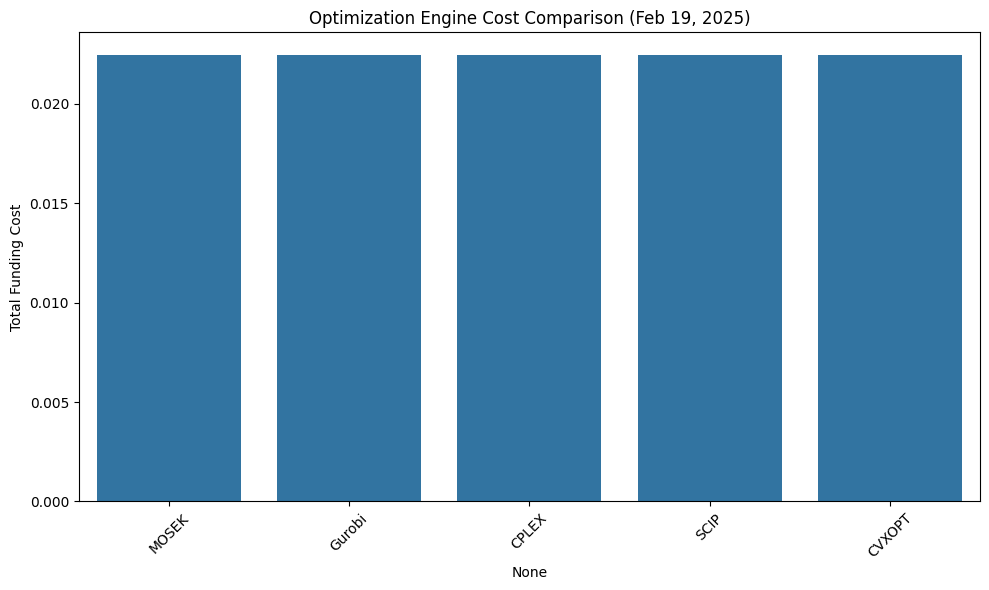

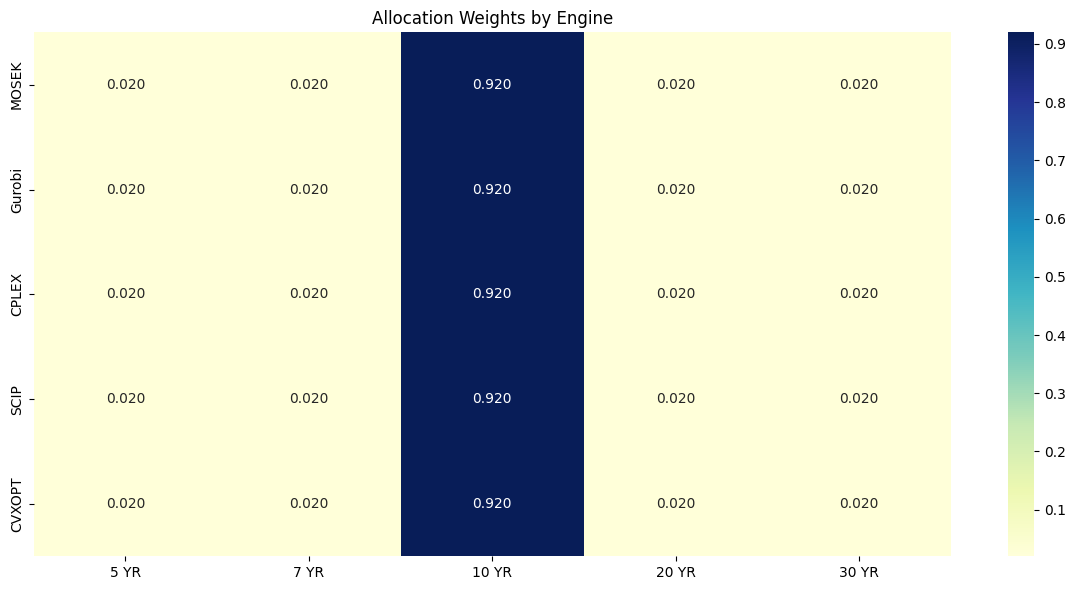

In [52]:
results = {
    "MOSEK": (w_mosek, cost_mosek),
    "Gurobi": (w_gurobi, cost_gurobi),
    "CPLEX": (w_cplex, cost_cplex),
    #"Xpress": (w_xpress, cost_xpress),
    "SCIP": (w_scip, cost_scip),
    "CVXOPT": (w_cvxopt, cost_cvxopt)
    #"KNITRO": (w_knitro, cost_knitro)
}

# Cost comparison
df_cost = pd.DataFrame({k: [v[1]] for k, v in results.items()}, index=["Cost"]).T

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=df_cost.index, y="Cost", data=df_cost)
plt.title("Optimization Engine Cost Comparison (Feb 19, 2025)")
plt.ylabel("Total Funding Cost")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Weights comparison
weights_df = pd.DataFrame(
    {k: v[0] for k, v in results.items()},
    index=["5 YR", "7 YR", "10 YR", "20 YR", "30 YR"]
).T
plt.figure(figsize=(12, 6))
sns.heatmap(weights_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Allocation Weights by Engine")
plt.tight_layout()
plt.show()

## Notes
- **Data**: Latest rates from 2024 used. Adjust URL if format changes.
- **Licenses**: MOSEK, Gurobi, CPLEX, Xpress (skipped could not install for Python 3.11), KNITRO (skipped could not install for Python 3.11) need licenses; SCIP and CVXOPT are free.
- **Performance**: All solvers should yield similar results for this linear problem.